In [1]:
import pandas as pd
import numpy as np
import random

communes = pd.read_csv("data/communes-france-2025.csv")
data = []
communes['latitude_weight'] = communes['latitude_mairie'].apply(
    lambda x: (1 - (x - communes['latitude_mairie'].min()) / (communes['latitude_mairie'].max() - communes['latitude_mairie'].min())) ** 2
)
communes['population_weight'] = communes['population'].apply(
    lambda x: (1 - (x - communes['population'].min()) / (communes['population'].max() - communes['population'].min())) ** 10
)
communes['altitude_weight'] = communes['altitude_moyenne'].apply(
    lambda x: (1 - (x - communes['altitude_moyenne'].min()) / (communes['altitude_moyenne'].max() - communes['altitude_moyenne'].min())) ** 3
)
communes['combined_weight'] = communes['latitude_weight'] + 4*communes['population_weight'] + communes['altitude_weight']

/tmp/ipykernel_15008/4088496440.py:5: DtypeWarning: Columns (1,12,14,16,23) have mixed types. Specify dtype option on import or set low_memory=False.
  communes = pd.read_csv("data/communes-france-2025.csv")


In [2]:
selected_communes = communes.sample(n=1000, weights=communes['combined_weight'])

In [71]:
data = []

def generate_geographical_customer_data_with_trends(communes, n_samples=5000, random_state=None, k_south_trend=2):
    for i, commune in selected_communes.iterrows():
        ville = commune['nom_standard']
        department_name = commune['dep_nom']
        lat = commune['latitude_mairie']
        lon = commune['longitude_mairie']
        population = commune['population']
        altitude = commune['altitude_moyenne']
        
        client_id = f"Client_{i+1}"
        age = np.random.randint(18, 80)
        annual_income = np.random.normal(loc=30000, scale=15000) * (1 + (age - 18) / 100)
        discount_applied = random.choice([True, False])
        # seasonal_preference = random.choice(['Winter', 'Spring', 'Summer', 'Fall'])
        # shipping_time = random.choice(['Fast', 'Average', 'Slow'])
        payment_method = random.choice(['Credit Card', 'PayPal', 'Bank Transfer'])
        product_category = random.choice(['Electronics', 'Clothing', 'Home Decor', 'Fitness Gear', 'Toys', 'Books'])
        repeat_customer = random.choice([True, False])
        loyalty_program_member = random.choice([True, False])
        time_of_day = random.choice(['Morning', 'Afternoon', 'Evening'])
        product_rating = np.random.randint(1, 6)
        return_probability = np.random.choice([True, False], p=[0.2, 0.8])
        shipping_cost = 5 + abs(np.random.normal(loc=10, scale=5))

        # Adjust purchase frequency based on age with added noise for variability
        purchase_frequency = np.random.normal(loc=5, scale=2) + (age // 10) * 0.1 + np.random.normal(loc=0, scale=1)

        # Adjust purchase frequency based on altitude and latitude (more frequent at lower latitudes)
        purchase_frequency += abs(np.random.normal(loc=altitude // 1000, scale=0.5))
        purchase_frequency *= (1 - lat / 90) ** k_south_trend

        # Adjust customer satisfaction based on shipping cost and age
        customer_satisfaction = np.random.randint(1, 6) + (shipping_cost // 5)
        customer_satisfaction -= np.random.normal(loc=age // 10, scale=1)  # More realistic, with some variation
        # also on discount applied
        customer_satisfaction += abs(np.random.normal(loc=1, scale=1)) if discount_applied else 0
        customer_satisfaction = abs(customer_satisfaction)
        
        # add mobile app weight on order_method if customer is young, in-store if old
        methods = ['Online', 'In-store', 'Mobile App']
        order_method = random.choices(methods, weights=[age/80, 1 - age/80, 0.5], k=1)[0]        

        # Generate sales score based on age, altitude, and population
        sale_score = age * 0.1 + altitude * 1.5 + population * 0.0001
        sale_score += np.random.normal(loc=0, scale=50)  # Added noise to the sales score
        purchase_amount = abs(np.random.normal(loc=sale_score, scale=500)) + random.randint(10,25)
        
        if payment_method == 'Credit Card':
            purchase_frequency += random.choice([0.5, 1, 1.5])
        purchase_frequency = abs(purchase_frequency)
        
        data.append({
            'ClientID': client_id,
            'Age': age,
            'AnnualIncome': annual_income,
            'PurchaseAmount': purchase_amount,
            'PurchaseFrequency': purchase_frequency,
            'CustomerSatisfaction': customer_satisfaction,
            'Region': department_name,
            'Ville': ville,
            'Latitude': lat,
            'Longitude': lon,
            'Population': population,
            'Altitude': altitude,
            'DiscountApplied': discount_applied,
            'OrderMethod': order_method,
            # 'SeasonalPreference': seasonal_preference,
            # 'ShippingTime': shipping_time,
            'PaymentMethod': payment_method,
            # 'ProductCategory': product_category,
            # 'RepeatCustomer': repeat_customer,
            # 'LoyaltyProgramMember': loyalty_program_member,
            # 'TimeOfDay': time_of_day,
            # 'ProductRating': product_rating,
            # 'ReturnProbability': return_probability,
            'ShippingCost': shipping_cost
        })
    
    df = pd.DataFrame(data)
    return df

# Generate customer data with geographical and trend-based adjustments
geo_customer_data_with_trends = generate_geographical_customer_data_with_trends(communes, n_samples=8287, k_south_trend=2)

In [72]:
import numpy as np
import pandas as pd

# Fonction pour ajouter des anomalies, des valeurs manquantes et des lignes vides
def add_anomalies_and_missing_values(df, anomaly_columns, missing_rate_range=(0.001, 0.005), duplicate_rate_range=(0.001, 0.005), outlier_rate_range=(0.001, 0.005), empty_row_rate=0.02, feature_anomaly_weights=None):
    # Générer des taux aléatoires
    missing_rate = np.random.uniform(*missing_rate_range)
    duplicate_rate = np.random.uniform(*duplicate_rate_range)
    outlier_rate = np.random.uniform(*outlier_rate_range)

    # Poids par défaut pour les colonnes si non fournis
    if feature_anomaly_weights is None:
        feature_anomaly_weights = {col: 1 for col in anomaly_columns}

    total_weight = sum(feature_anomaly_weights.values())

    # Ajouter des valeurs manquantes à toutes les colonnes
    for col in df.columns:
        num_missing = int(len(df) * missing_rate)
        missing_indices = np.random.choice(df.index, num_missing, replace=False)
        df.loc[missing_indices, col] = np.nan

    # Ajouter des doublons
    num_duplicates = int(len(df) * duplicate_rate)
    duplicate_indices = np.random.choice(df.index, num_duplicates, replace=False)
    duplicates = df.loc[duplicate_indices]
    df = pd.concat([df, duplicates], ignore_index=True)

    # Ajouter des outliers spécifiques aux colonnes d'anomalies
    for col, weight in feature_anomaly_weights.items():
        if col in anomaly_columns:
            col_weight = weight / total_weight
            num_outliers = int(len(df) * outlier_rate * col_weight)
            outlier_indices = np.random.choice(df.index, num_outliers, replace=False)
            if col == 'PurchaseAmount':
                # Montants d'achat extrêmes
                df.loc[outlier_indices, col] = np.random.choice([-1e6, 1e6], size=num_outliers)
            elif col == 'PurchaseFrequency':
                # Fréquence d'achat extrême
                df.loc[outlier_indices, col] = np.random.choice([0, 100], size=num_outliers)
            elif col == 'CustomerSatisfaction':
                # Satisfaction client extrême
                df.loc[outlier_indices, col] = np.random.choice([0, 100], size=num_outliers)
            elif col == 'ShippingCost':
                # Coût d'expédition extrême
                df.loc[outlier_indices, col] = np.random.choice([0, 5000], size=num_outliers)

    # Ajouter des lignes vides
    num_empty_rows = int(len(df) * empty_row_rate)
    empty_rows = pd.DataFrame(np.nan, index=range(num_empty_rows), columns=df.columns)
    df = pd.concat([df, empty_rows], ignore_index=True)

    return df

# Colonnes pour lesquelles ajouter des anomalies spécifiques
anomaly_columns = ['PurchaseAmount', 'PurchaseFrequency', 'CustomerSatisfaction', 'ShippingCost']

# Poids non uniformes pour les anomalies par colonne
feature_anomaly_weights = {
    'PurchaseAmount': 3,
    'PurchaseFrequency': 2,
    'CustomerSatisfaction': 1,
    'ShippingCost': 4
}

# Appliquer les anomalies, valeurs manquantes et lignes vides
geo_customer_data_with_anomalies = add_anomalies_and_missing_values(
    geo_customer_data_with_trends,
    anomaly_columns,
    feature_anomaly_weights=feature_anomaly_weights
)

# Afficher un aperçu des données avec anomalies et valeurs manquantes
geo_customer_data_with_anomalies.sample(20)

/tmp/ipykernel_15008/3411761530.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[missing_indices, col] = np.nan


,ClientID,Age,AnnualIncome,PurchaseAmount,PurchaseFrequency,CustomerSatisfaction,Region,Ville,Latitude,Longitude,Population,Altitude,DiscountApplied,OrderMethod,PaymentMethod,ShippingCost
4,Client_5550,63.0,22640.184363,328.579391,2.883312,3.556367,Charente,Vindelle,45.720,0.121,1062.0,55.0,True,Online,Credit Card,17.512980
231,Client_5449,45.0,45483.599698,441.697276,1.851752,4.535459,Charente,Roullet-Saint-Estèphe,45.584,0.047,4312.0,65.0,True,Online,Credit Card,25.924679
803,Client_26,74.0,46815.332460,78.594400,0.968902,1.646216,Ain,Beaupont,46.410,5.265,700.0,205.0,False,Online,PayPal,19.178191
68,Client_11677,26.0,35879.122934,419.200834,1.155562,0.953663,Haute-Garonne,Pins-Justaret,43.479,1.382,4356.0,159.0,True,Online,Credit Card,12.256654
656,Client_25378,68.0,49236.904666,968.385685,1.939609,2.820144,Pyrénées-Atlantiques,Soumoulou,43.266,-0.190,1584.0,284.0,True,Mobile App,PayPal,17.206794
167,Client_327,33.0,23280.898341,894.439280,0.343955,3.670531,Ain,Sainte-Olive,46.019,4.934,331.0,289.0,True,Online,PayPal,26.767406
425,Client_6584,34.0,63423.062347,107.163693,1.178897,2.190587,Corrèze,Vignols,45.319,1.390,531.0,297.0,True,In-store,Bank Transfer,11.034820
913,Client_26237,18.0,29082.809779,92.251078,1.505599,7.773415,Bas-Rhin,Forstfeld,48.859,8.039,793.0,115.0,True,In-store,Bank Transfer,26.633960
543,Client_29118,76.0,96488.568105,1270.097009,1.492719,1.366804,Haute-Savoie,Jonzier-Épagny,46.070,5.990,835.0,651.0,True,Mobile App,PayPal,12.677463
517,Client_27607,35.0,39042.563259,112.404702,0.887925,1.846868,Haute-Saône,Motey-Besuche,47.305,5.665,90.0,251.0,False,Online,Bank Transfer,12.389827


In [73]:
geo_customer_data_with_anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ClientID              1000 non-null   object 
 1   Age                   1000 non-null   float64
 2   AnnualIncome          1000 non-null   float64
 3   PurchaseAmount        1000 non-null   float64
 4   PurchaseFrequency     1000 non-null   float64
 5   CustomerSatisfaction  1000 non-null   float64
 6   Region                1000 non-null   object 
 7   Ville                 1000 non-null   object 
 8   Latitude              1000 non-null   float64
 9   Longitude             1000 non-null   float64
 10  Population            1000 non-null   float64
 11  Altitude              1000 non-null   float64
 12  DiscountApplied       1000 non-null   object 
 13  OrderMethod           1000 non-null   object 
 14  PaymentMethod         1000 non-null   object 
 15  ShippingCost         

In [74]:
geo_customer_data_with_anomalies.to_csv("data/clients_v2.csv", index=False)

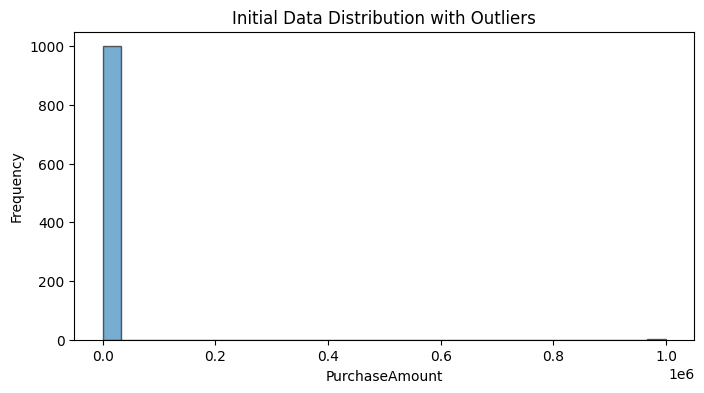

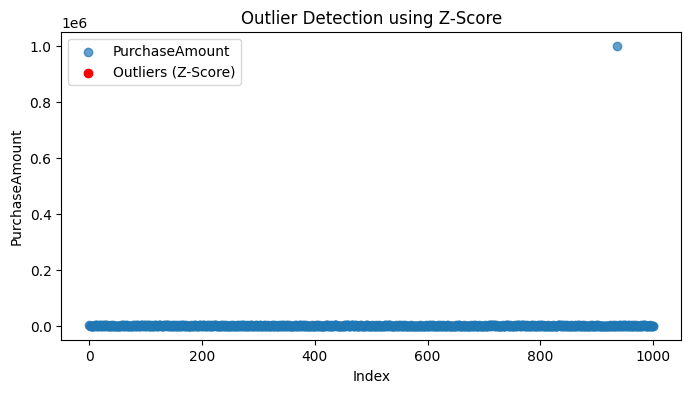

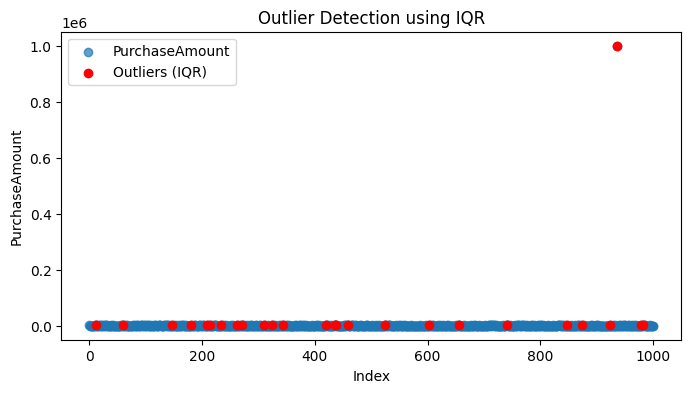

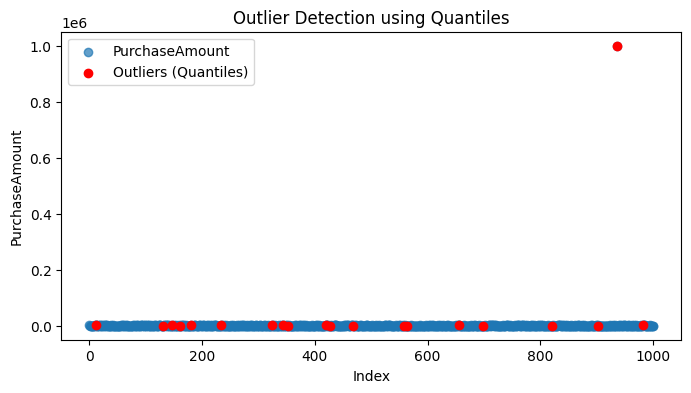

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Assuming geo_customer_data_with_anomalies is already defined with 'PurchaseAmount'
# Example placeholder for the dataset if needed:
# geo_customer_data_with_anomalies = pd.DataFrame({"PurchaseAmount": np.random.normal(50, 15, 100)})

# Focus on 'PurchaseAmount'
data = geo_customer_data_with_anomalies['PurchaseAmount']

# Initial Visualization
plt.figure(figsize=(8, 4))
plt.hist(data, bins=30, alpha=0.6, edgecolor="k")
plt.title("Initial Data Distribution with Outliers")
plt.xlabel("PurchaseAmount")
plt.ylabel("Frequency")
plt.show()

# Method 1: Z-Score
z_scores = zscore(data)
threshold = 3
outliers_zscore = np.abs(z_scores) > threshold

# Visualization of Outliers (Z-Score)
plt.figure(figsize=(8, 4))
plt.scatter(data.index, data, alpha=0.7, label="PurchaseAmount")
plt.scatter(data.index[outliers_zscore], 
            data[outliers_zscore], 
            color="red", label="Outliers (Z-Score)", zorder=5)
plt.title("Outlier Detection using Z-Score")
plt.xlabel("Index")
plt.ylabel("PurchaseAmount")
plt.legend()
plt.show()

# Method 2: IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))

# Visualization of Outliers (IQR)
plt.figure(figsize=(8, 4))
plt.scatter(data.index, data, alpha=0.7, label="PurchaseAmount")
plt.scatter(data.index[outliers_iqr], 
            data[outliers_iqr], 
            color="red", label="Outliers (IQR)", zorder=5)
plt.title("Outlier Detection using IQR")
plt.xlabel("Index")
plt.ylabel("PurchaseAmount")
plt.legend()
plt.show()

# Method 3: Quantiles
low_threshold = data.quantile(0.01)
high_threshold = data.quantile(0.99)
outliers_quantiles = (data < low_threshold) | (data > high_threshold)

# Visualization of Outliers (Quantiles)
plt.figure(figsize=(8, 4))
plt.scatter(data.index, data, alpha=0.7, label="PurchaseAmount")
plt.scatter(data.index[outliers_quantiles], 
            data[outliers_quantiles], 
            color="red", label="Outliers (Quantiles)", zorder=5)
plt.title("Outlier Detection using Quantiles")
plt.xlabel("Index")
plt.ylabel("PurchaseAmount")
plt.legend()
plt.show()


In [76]:
geo_customer_data_with_anomalies.to_csv("data/clients_v2.csv", index=False)

# HTML Conversion script

In [1]:
import nbformat
from nbconvert import HTMLExporter

# Load the notebook file
with open('9.0._data_gen.ipynb', 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)

# Create an HTML exporter
html_exporter = HTMLExporter()

# Convert the notebook to HTML
body, resources = html_exporter.from_notebook_node(notebook_content)

# Save the HTML to a file
with open('output_notebook.html', 'w', encoding='utf-8') as f:
    f.write(body)

print("Notebook successfully converted to HTML!")


Notebook successfully converted to HTML!


# Data_gen v2

In [3]:
import pandas as pd
import uuid
import random
import numpy as np

def generate_data_v2(n_samples=5000) -> pd.DataFrame:
    data = []
    
    for i in range(n_samples):
        client_id = uuid.uuid4()
        age = random.randint(18, 80)
        gender = random.choice(['M', 'F'])
        
        
        # Determine article type based on age and gender
        if age >= 50:
            article_type = random.choices(
                ['Home Decor', 'Electronics', 'Clothing'],
                weights=[0.7, 0.2, 0.1] if gender == 'M' else [0.7, 0.1, 0.2]
            )[0]
        elif age <= 40:
            article_type = random.choices(
                ['Toys', 'Electronics', 'Clothing'],
                weights=[0.6, 0.3, 0.1] if gender == 'M' else [0.6, 0.1, 0.3]
            )[0]
        else:
            article_type = random.choice(['Home Decor', 'Toys', 'Electronics', 'Clothing'])

        purchase_amount = round(np.random.normal(50, 20), 2)  # Normally distributed purchase amount
        discount_received = random.choices([True, False], weights=[0.3, 0.7])[0]
        time_of_purchase = random.randint(0, 23)  # Hour of purchase
        
        # Customer loyalty score
        loyalty_score = round(
            (age / 80) * 100 + (purchase_amount / 200) * 100 + (20 if discount_received else 0) + 
            (10 if article_type in ['Electronics', 'Clothing'] else 0), 
            2
        )
        
        data.append({
            'client_id': str(client_id),
            'age': age,
            'gender': gender,
            'article_type': article_type,
            'purchase_amount': max(0, purchase_amount),  # Ensure no negative purchase amounts
            'discount_received': discount_received,
            'time_of_purchase': time_of_purchase,
            'loyalty_score': loyalty_score
        })

    return pd.DataFrame(data)

# Example usage
df = generate_data_v2()
df.sample(5)

,client_id,age,gender,article_type,purchase_amount,discount_received,time_of_purchase,loyalty_score
3507,1f839fa1-c01f-4277-a8e2-4d0fde7d4e2e,55,M,Home Decor,8.69,True,7,93.09
315,504b27b5-5adc-41d3-af78-a8148c7e83dc,24,F,Electronics,67.97,True,14,93.98
1896,a3b51383-389c-4a35-a982-25bf503ee002,18,M,Toys,21.48,False,11,33.24
949,c506de2b-56ca-4601-949f-9efa5c979025,49,M,Toys,38.53,True,8,100.52
1174,85909319-24dd-4720-9313-ebaca15fe379,67,M,Electronics,45.08,False,8,116.29


In [9]:
import pandas as pd
import uuid
import random
import numpy as np

def generate_data_v2(n_samples=5000) -> pd.DataFrame:
    data = []
    regions = ['North', 'South', 'East', 'West', 'Central']
    payment_methods = ['Credit Card', 'Debit Card', 'PayPal', 'Bank Transfer', 'Cash']
    delivery_options = ['Standard', 'Express', 'Same Day', 'Pickup']
    
    for i in range(n_samples):
        # client_id = uuid.uuid4()
        client_id = i
        age = random.randint(18, 80)
        gender = random.choice(['M', 'F'])
        region = random.choices(regions, weights=[0.2, 0.3, 0.2, 0.2, 0.1])[0]
        
        # Determine article type based on age and gender
        if age >= 50:
            article_type = random.choices(
                ['Home Decor', 'Electronics', 'Clothing'],
                weights=[0.7, 0.2, 0.1] if gender == 'M' else [0.7, 0.1, 0.2]
            )[0]
        elif age <= 40:
            article_type = random.choices(
                ['Toys', 'Electronics', 'Clothing'],
                weights=[0.6, 0.3, 0.1] if gender == 'M' else [0.6, 0.1, 0.3]
            )[0]
        else:
            article_type = random.choice(['Home Decor', 'Toys', 'Electronics', 'Clothing'])

        purchase_amount = round(np.random.normal(50, 20), 2)  # Normally distributed purchase amount
        discount_received = random.choices([True, False], weights=[0.3, 0.7])[0]
        time_of_purchase = random.randint(0, 23)
        payment_method = random.choices(payment_methods, weights=[0.4, 0.3, 0.2, 0.05, 0.05])[0]
        delivery_option = random.choices(delivery_options, weights=[0.5, 0.3, 0.1, 0.1])[0]
        
        # Customer loyalty score
        loyalty_score = round(
            (age / 80) * 100 + (purchase_amount / 200) * 100 + (20 if discount_received else 0) + 
            (10 if article_type in ['Electronics', 'Clothing'] else 0), 
            2
        )
        
        # Adjust trends based on attributes
        if delivery_option == 'Express':
            purchase_amount += 50  # Higher cost for faster delivery
        if payment_method == 'Cash':
            purchase_amount -= 30  # Slightly lower loyalty for cash payments
        
        data.append({
            'client_id': str(client_id),
            'age': age,
            'gender': gender,
            'region': region,
            'article_type': article_type,
            'purchase_amount': max(0, purchase_amount),  # Ensure no negative purchase amounts
            'discount_received': discount_received,
            'time_of_purchase': time_of_purchase,
            'payment_method': payment_method,
            'delivery_option': delivery_option,
            'loyalty_score': loyalty_score
        })

    return pd.DataFrame(data)

# Example usage
df = generate_data_v2()
df.head()


,client_id,age,gender,region,article_type,purchase_amount,discount_received,time_of_purchase,payment_method,delivery_option,loyalty_score
0,0,43,F,East,Clothing,98.49,False,0,Credit Card,Express,88.00
1,1,21,F,North,Electronics,51.59,True,9,Credit Card,Same Day,82.05
2,2,78,F,East,Home Decor,55.72,False,13,PayPal,Standard,125.36
3,3,47,M,West,Home Decor,65.27,False,5,Debit Card,Standard,91.38
4,4,80,F,East,Clothing,45.80,True,1,PayPal,Standard,152.90


# Matrice de corrélation

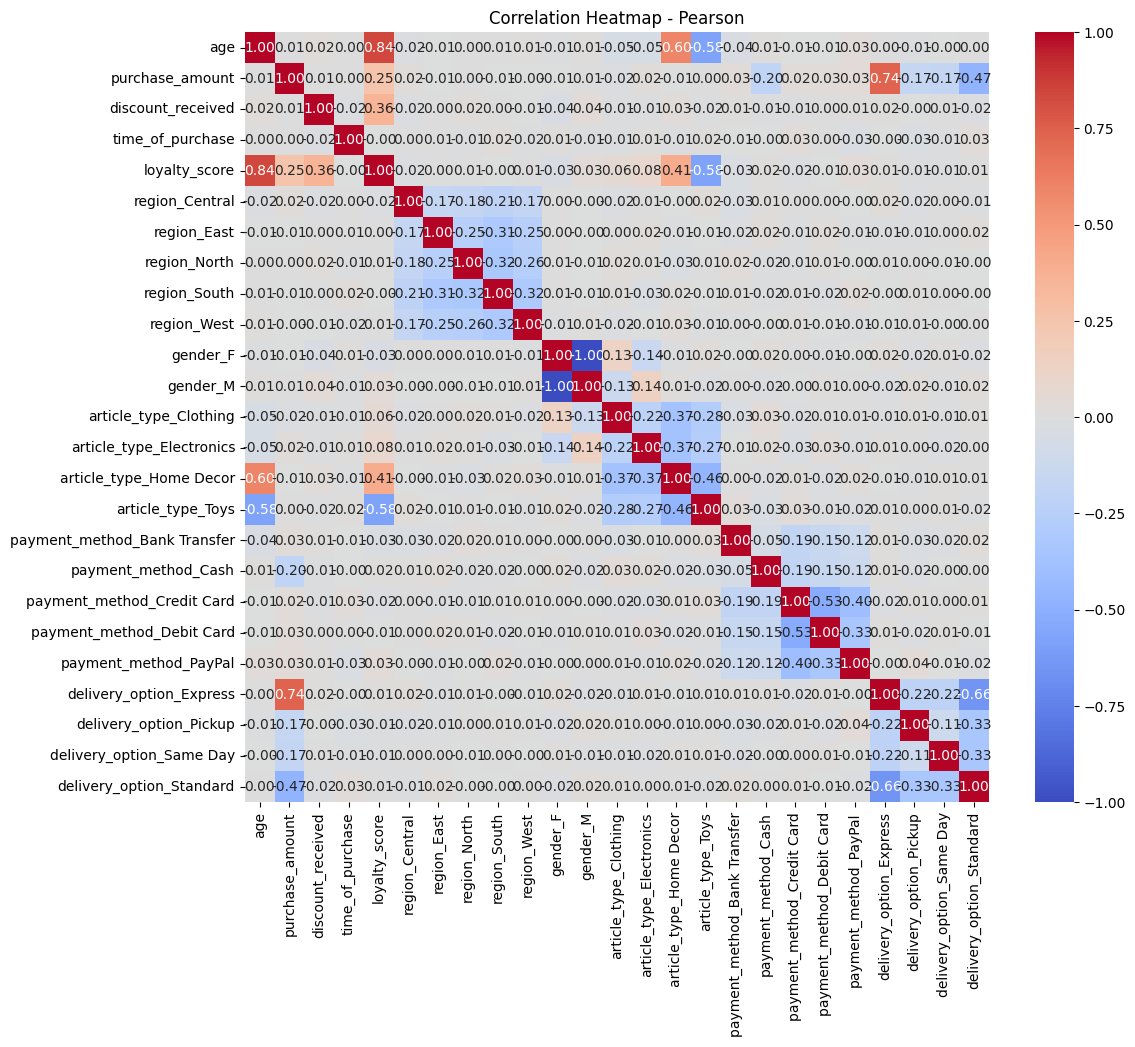

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame structure
# df = pd.DataFrame(...) # Assuming your DataFrame is already loaded

# One-hot encode categorical columns
encoded_df = pd.get_dummies(
    df.drop(columns=["client_id"]),  # Drop client_id
    columns=["region", "gender", "article_type", "payment_method", "delivery_option"],
    # drop_first=True  # Avoid multicollinearity
)

# Compute the correlation matrix
correlation_matrix = encoded_df.corr(method="pearson")
# correlation_matrix = encoded_df.corr(method="spearman")

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap - Pearson")
plt.show()


# Bivariate analysis

### age / loyalty_score

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data
X = df[['age']]  # Independent variable (age)
y = df['loyalty_score']  # Dependent variable (loyalty_score)

# Initialize the LinearRegression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Predict the loyalty scores using the model
y_pred = model.predict(X)

# Example: Predict loyalty score for a specific age
age_to_predict = 35
age_df = pd.DataFrame({'age': [age_to_predict]})
predicted_loyalty_score = model.predict(age_df)

print(f"Predicted loyalty score for age {age_to_predict}: {predicted_loyalty_score[0]}")

Predicted loyalty score for age 35: 78.53014952328598


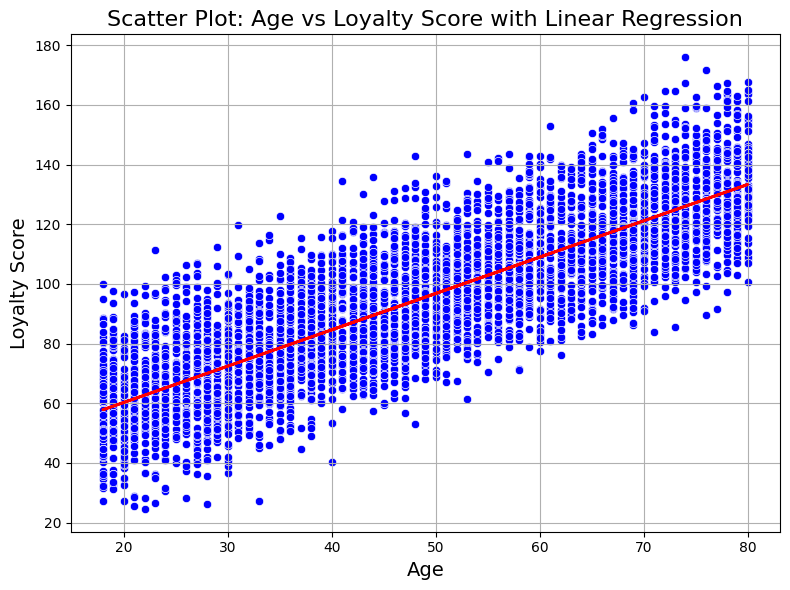

In [36]:
# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='loyalty_score', data=df, color='blue')

# Plot the regression line
plt.plot(df['age'], y_pred, color='red', linewidth=2)

# Add title and labels
plt.title('Scatter Plot: Age vs Loyalty Score with Linear Regression', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Loyalty Score', fontsize=14)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
### 